# Tree based methods

J. Renero<br>
January 2019

Trees construct prediction models from data. They recursively partition the data space to fit a boolean prediction model within each partition. The result is represented graphically as a decision tree. Trees can be used for regression of classification.

When the number of features, $p$, is large interpretability is easier than in distance based methods or probabilistic classification, where boundaries are much more difficult to be explained in higer dimensions.

For better visualizations of the trees, explore [dtreeviz](https://github.com/parrt/dtreeviz)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tree-based-methods" data-toc-modified-id="Tree-based-methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tree based methods</a></span><ul class="toc-item"><li><span><a href="#Regression-Example" data-toc-modified-id="Regression-Example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Regression Example</a></span><ul class="toc-item"><li><span><a href="#Load-the-data-and-split-the-dataset" data-toc-modified-id="Load-the-data-and-split-the-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load the data and split the dataset</a></span></li><li><span><a href="#Fit-a-simple-regression-tree-(no-CV)" data-toc-modified-id="Fit-a-simple-regression-tree-(no-CV)-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fit a simple regression tree (no CV)</a></span></li><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-Importance" data-toc-modified-id="Variables-Importance-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Variables Importance</a></span></li><li><span><a href="#Understanding-the-tree-structure-(partially-from-here)" data-toc-modified-id="Understanding-the-tree-structure-(partially-from-here)-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Understanding the tree structure (partially from <a href="https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py" target="_blank">here</a>)</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Evaluating the tree</a></span></li></ul></li><li><span><a href="#Classification-Example" data-toc-modified-id="Classification-Example-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classification Example</a></span><ul class="toc-item"><li><span><a href="#Display-the-tree" data-toc-modified-id="Display-the-tree-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Display the tree</a></span></li><li><span><a href="#Variables-importance" data-toc-modified-id="Variables-importance-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Variables importance</a></span></li><li><span><a href="#Evaluating-the-tree" data-toc-modified-id="Evaluating-the-tree-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluating the tree</a></span></li><li><span><a href="#Manually-finding-the-optimal-tree-depth" data-toc-modified-id="Manually-finding-the-optimal-tree-depth-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Manually finding the optimal tree depth</a></span></li><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Working-with-the-probabilities-of-the-estimations" data-toc-modified-id="Working-with-the-probabilities-of-the-estimations-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Working with the probabilities of the estimations</a></span></li></ul></li><li><span><a href="#Optimization-techniques" data-toc-modified-id="Optimization-techniques-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Optimization techniques</a></span><ul class="toc-item"><li><span><a href="#Bagging" data-toc-modified-id="Bagging-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Bagging</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Boosting</a></span></li></ul></li><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Hyperparameter tuning</a></span></li><li><span><a href="#Adding-interpretability" data-toc-modified-id="Adding-interpretability-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Adding interpretability</a></span><ul class="toc-item"><li><span><a href="#Interpretability,-through-simple-surrogate-models" data-toc-modified-id="Interpretability,-through-simple-surrogate-models-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Interpretability, through simple surrogate models</a></span></li></ul></li></ul></li><li><span><a href="#Isolation-Trees" data-toc-modified-id="Isolation-Trees-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Isolation Trees</a></span><ul class="toc-item"><li><span><a href="#Example-with-Mopsi-location-dataset" data-toc-modified-id="Example-with-Mopsi-location-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example with Mopsi location dataset</a></span></li></ul></li></ul></div>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import graphviz
import warnings

from IPython.display import Image
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.validation import column_or_1d

from lime.lime_tabular import LimeTabularExplainer

from dataset import Dataset

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

%matplotlib inline

## Regression Example

We will start by building a simple regression example with the [wholesale customer dataset in UCI](https://archive.ics.uci.edu/ml/datasets/wholesale+customers). It contains 440 samples of 8 variables, and we will try to build a model that will help us to predict the annual spending on fresh products (first variable) with a regression tree.

### Load the data and split the dataset

In [30]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.set_target('Fresh')
X, Y = wholesale.split()
wholesale.summary()


Features Summary:
'Channel'         : float64    Min.(1.0) 1stQ(1.0) Med.(1.0) Mean(1.32) 3rdQ(2.0) Max.(2.0)
'Region'          : float64    Min.(1.0) 1stQ(2.0) Med.(3.0) Mean(2.54) 3rdQ(3.0) Max.(3.0)
'Milk'            : float64    Min.(55.0) 1stQ(1533) Med.(3627) Mean(5796) 3rdQ(7190) Max.(7349)
'Grocery'         : float64    Min.(3.0) 1stQ(2153) Med.(4755) Mean(7951) 3rdQ(1065) Max.(9278)
'Frozen'          : float64    Min.(25.0) 1stQ(742.) Med.(1526) Mean(3071) 3rdQ(3554) Max.(6086)
'Detergents_Paper': float64    Min.(3.0) 1stQ(256.) Med.(816.) Mean(2881) 3rdQ(3922) Max.(4082)
'Delicassen'      : float64    Min.(3.0) 1stQ(408.) Med.(965.) Mean(1524) 3rdQ(1820) Max.(4794)


In [31]:
wholesale.data.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Fit a simple regression tree (no CV)

In [32]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
regressor.fit(X.train, Y.train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

### Display the tree

Things get a bit complicated to plot the tree (this time, R is better than Python...). I pack eveything needed in a function so I can reuse it later on.

In [33]:
def display_tree(tree, features):
    dot_data = StringIO()
    export_graphviz(tree, 
                    out_file=dot_data,
                    feature_names=features,
                    filled=True, 
                    rounded=True,
                    node_ids=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    image = Image(graph.create_png())
    display(image)

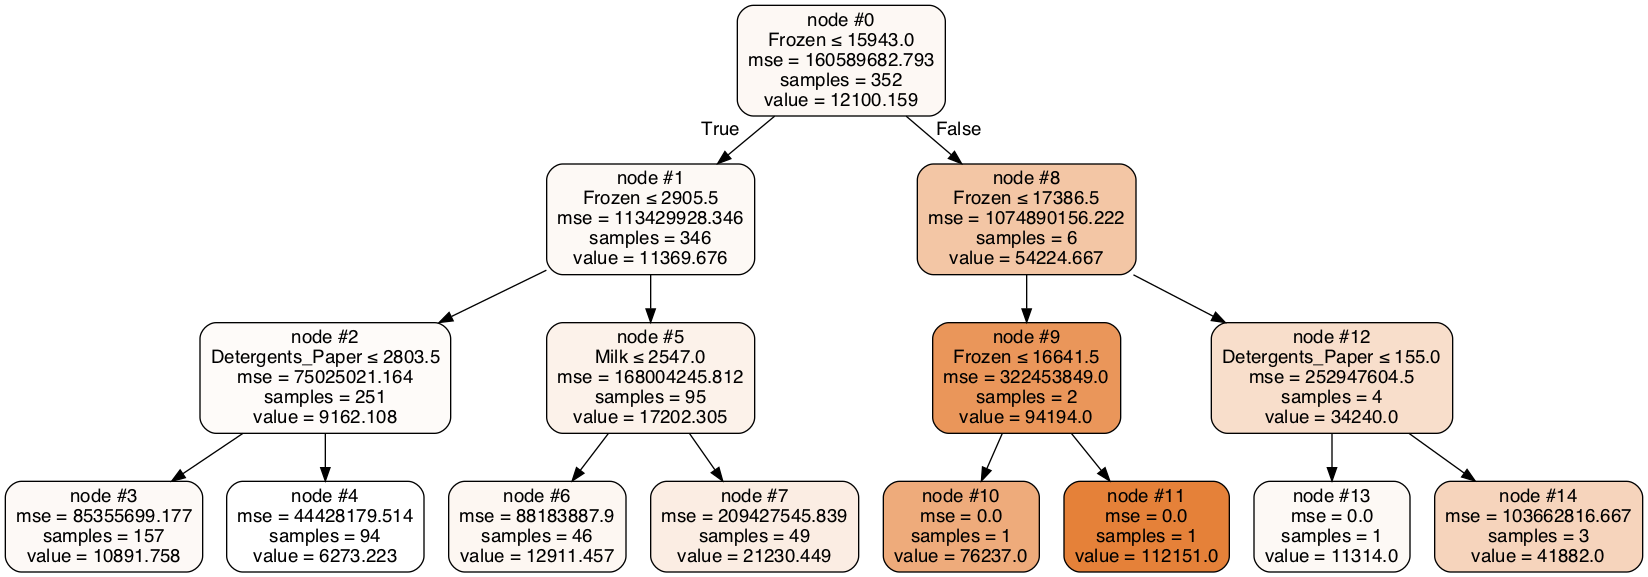

In [34]:
display_tree(regressor, wholesale.names('features'))

### Variables Importance

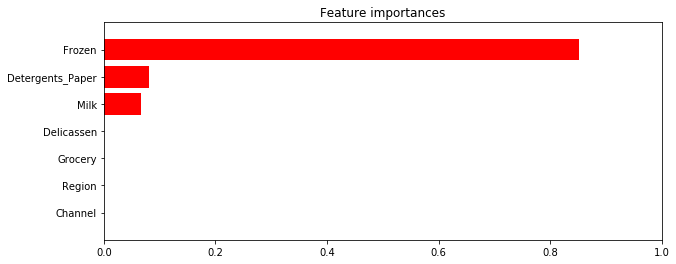

In [35]:
def features_importance(tree, X):
    """
    Plot the variables importance from the fitted tree and the 
    training dataset used.
    """
    importances = tree.feature_importances_
    indices = np.argsort(importances)
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,4))
    plt.title("Feature importances")
    plt.barh(range(X.train.shape[1]), importances[indices],
           color="r", align="center")
    index_names = [list(X.train)[i] for i in indices]
    plt.yticks(range(X.train.shape[1]), index_names)
    plt.ylim([-1, X.train.shape[1]])
    plt.xlim([0.0, 1.0])
    plt.show()

features_importance(regressor, X)

### Understanding the tree structure (partially from [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py))

From an example in SciKit Learn pages. Do not try this at home!

In [36]:
def explain_tree(regressor):
    n_nodes = regressor.tree_.node_count
    children_left = regressor.tree_.children_left
    children_right = regressor.tree_.children_right
    feature = regressor.tree_.feature
    threshold = regressor.tree_.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s (leaf node)" % (node_depth[i] * "  ", i))
        else:
            print("%snode=%s: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "  ",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))

explain_tree(regressor)

The binary tree structure has 15 nodes and has the following tree structure:
node=0: go to node 1 if X[:, 4] <= 15943.0 else to node 8.
  node=1: go to node 2 if X[:, 4] <= 2905.5 else to node 5.
    node=2: go to node 3 if X[:, 5] <= 2803.5 else to node 4.
      node=3 (leaf node)
      node=4 (leaf node)
    node=5: go to node 6 if X[:, 2] <= 2547.0 else to node 7.
      node=6 (leaf node)
      node=7 (leaf node)
  node=8: go to node 9 if X[:, 4] <= 17386.5 else to node 12.
    node=9: go to node 10 if X[:, 4] <= 16641.5 else to node 11.
      node=10 (leaf node)
      node=11 (leaf node)
    node=12: go to node 13 if X[:, 5] <= 155.0 else to node 14.
      node=13 (leaf node)
      node=14 (leaf node)


### Evaluating the tree

What's the __MSE__ of this tree when making predictions? We **never** evaluate a predictor using a single split or a single measure. Instead, we apply CV to evaluate its performance, on average, over different splits from the training set, to foresee what is its expected performance in training, no matter what portion of the data is used to train the algorithm.

To finally evaluate the tree, we must compute the same metric over the test set, without CV (no extra levels of paranoia, yet).

In [89]:
regression_tree = DecisionTreeRegressor(
    random_state=0, max_depth=3).fit(X.train, Y.train)

base_training_mse = np.abs(np.mean(cross_val_score(
        regression_tree, 
        X.train, Y.train, 
        scoring='neg_mean_squared_error')))
print('Training MSE: {:.4f}'.format(base_training_mse))

base_test_mse = mean_squared_error(Y.test, regression_tree.predict(X.test))
print('Test MSE: {:.4f}'.format(base_test_mse))

Training MSE: 0.0572
Test MSE: 0.0906


If we evaluate the regressor with the function just described above, for a range of trees where the maximum depth ranges from 3 to 20, what we can see is the result oscilates a little bit but they're not specially good. The performance of a regression tree in this problem is specially bad. **Trees are not very good for regression problems** with features in a continuous space.

Optimal depth for the regression is proabbly "4", where we can find a turning point.

In [58]:
def plot_metrics(array1, array2, title='', xlabel='Tree depth', ylabel='F1'):
    array1 = np.abs(array1)
    array2 = np.abs(array2)
    plt.figure(figsize=(8, 5))
    plt.plot(array1, 'o-', label='Training')
    plt.plot(array2, 'o-', label='Test')
    plt.xticks(range(min_depth-1, max_depth-1),
               ['{}'.format(i) for i in range(min_depth, max_depth)])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show();

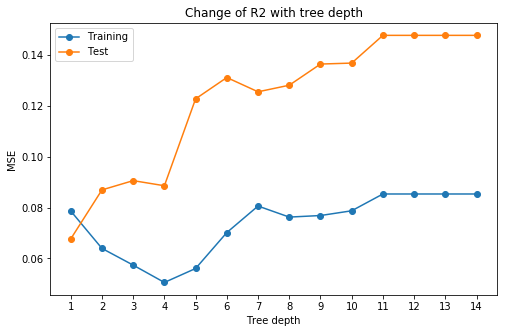

In [59]:
# Plot the $R^2$ values obtained when varying the depth of the tree
min_depth = 1
max_depth = 15
r2s_train = []
r2s_test = []
for i in range(min_depth, max_depth):
    # Fit the tree
    tree = DecisionTreeRegressor(
        random_state=0, max_depth=i).fit(X.train, Y.train)
    
    # Get 10 metrics using CV of the MSE
    r2s_train.append(np.mean(cross_val_score(
        tree, X.train, Y.train, scoring='neg_mean_squared_error', cv=10)))
    
    # Evaluate over the hold-out dataset.
    r2s_test.append(np.abs(mean_squared_error(Y.test, tree.predict(X.test))))
    del(tree)

plot_metrics(r2s_train, r2s_test, "Change of R2 with tree depth", ylabel='MSE')

What is the best MSE that we can obtain, given that we set the optimal depth = 4 ??

In [90]:
opt_regressor = DecisionTreeRegressor(
    random_state=0, max_depth=4).fit(X.train, Y.train)

opt_training_mse = np.abs(np.mean(cross_val_score(
        opt_regressor, 
        X.train, Y.train, 
        scoring='neg_mean_squared_error')))
print('Training MSE: {:.4f}'.format(opt_training_mse))

opt_test_mse = mean_squared_error(Y.test, opt_regressor.predict(X.test))
print('Test MSE: {:.4f}'.format(opt_test_mse))

Training MSE: 0.0639
Test MSE: 0.0886


As expected, the training MSE value is better than in test. And if we **compare** the results with the optimal tree, against the base tree grown using suboptimal max_depth, there's a clear improvement. It's always important to tune your algorithm parameters.

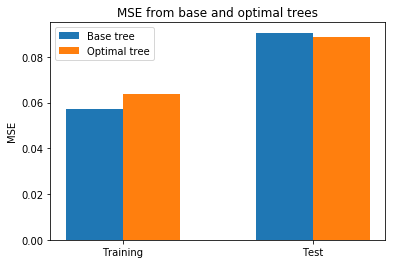

In [91]:
base = [base_tree_training_mse, base_tree_test_mse]
opt = [opt_tree_training_mse, opt_tree_test_mse]

barWidth = 0.3
r1 = np.arange(len(base))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, base, width = barWidth, label='Base tree')
plt.bar(r2, opt, width = barWidth, label='Optimal tree')
plt.xticks([r + barWidth/2 for r in range(len(base))], ['Training', 'Test'])
plt.title('MSE from base and optimal trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Classification Example

Let's build, using the same dataset a classification case. To do so the goal of this new model will be predicting the channel used by the customer (1 or 2), so we have a **binomial** classification problem.

In [39]:
wholesale = Dataset(data_url)
wholesale.set_target('Channel')

X, Y = wholesale.split()

classifier = DecisionTreeClassifier(random_state=0, max_depth=3)
classifier.fit(X.train, Y.train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Display the tree

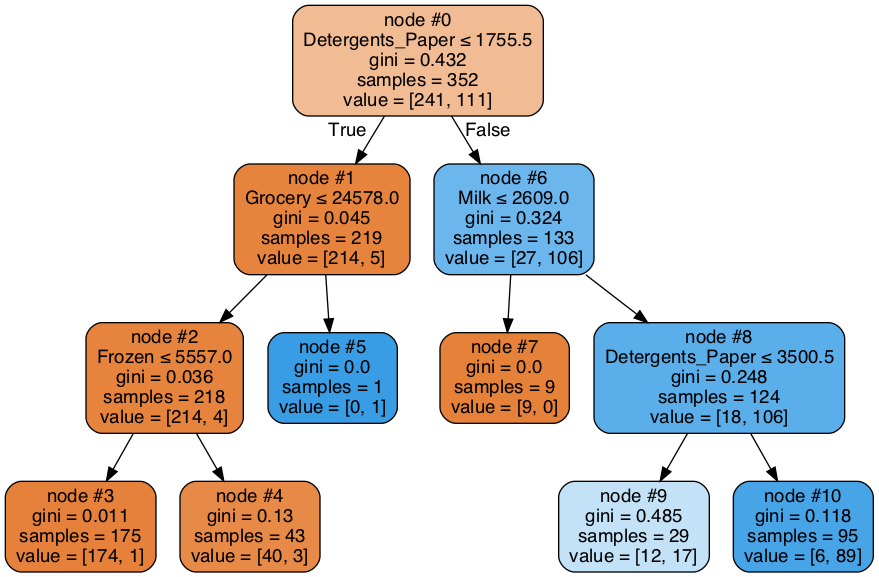

In [40]:
display_tree(classifier, wholesale.names('features'))

In [41]:
explain_tree(classifier)

The binary tree structure has 11 nodes and has the following tree structure:
node=0: go to node 1 if X[:, 5] <= 1755.5 else to node 6.
  node=1: go to node 2 if X[:, 3] <= 24578.0 else to node 5.
    node=2: go to node 3 if X[:, 4] <= 5557.0 else to node 4.
      node=3 (leaf node)
      node=4 (leaf node)
    node=5 (leaf node)
  node=6: go to node 7 if X[:, 2] <= 2609.0 else to node 8.
    node=7 (leaf node)
    node=8: go to node 9 if X[:, 5] <= 3500.5 else to node 10.
      node=9 (leaf node)
      node=10 (leaf node)


### Variables importance

Feature importance is calculated as the decrease in **node impurity weighted by the probability of reaching that node**. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

Scikit learns computes the node importance using the following expression to compute the node importance:

\begin{equation}
    ni_j = w_j C_j - w_{left(j)} C_{left(j)} - w_{right(j)} C_{right(j)}
\end{equation}

where:

- $ni_j$: the importance of node $j$
- $w_j$: weighted nr. of samples reaching node $j$
- $C_j$: Impurity of node $j$
- $left(j)$ / $right(j)$: child node from left/right split on node $j$

and then, **features importance** is computed as follows:

\begin{equation}
    fi_i = \frac{ \sum_{j:node\ j\ splits\ on\ feature\ i} ni_j }{ \sum_{k\ \in \ all\ nodes} ni_k }
\end{equation}

Feature importance of a feature is a sum of importances of the nodes where that feature is used to take a split decision.

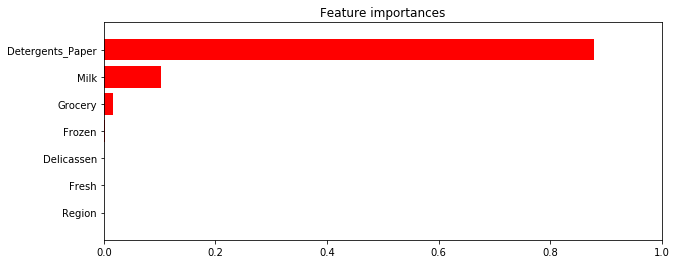

In [42]:
features_importance(classifier, X)

### Evaluating the tree

This case, the evaluation metric is the GINI index. Let's look how the different "impurity" indicators behave with regard to the probability distribution of classes.

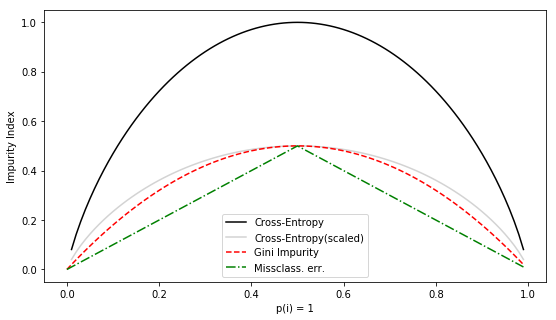

In [43]:
# Plot the Entropy, Gini Index and missclassification error curves
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1 - p))

def cross_entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
ent = [cross_entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

plt.figure(figsize=(9,5))
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                        ['Cross-Entropy','Cross-Entropy(scaled)',
                        'Gini Impurity', 'Missclass. err.'],
                        ['-','-','--','-.'],
                        ['black','lightgrey','red','green','cyan']):
    line = plt.plot(x, i, label=lab, linestyle=ls, color=c)
plt.legend(loc='best')
plt.xlabel('p(i) = 1')
plt.ylabel('Impurity Index')
plt.show()

Evaluate the tree in training and test (hold out split):

1. Obtain an estimate of the training average performance metric (F1)
2. Train a model with the entire dataset
3. Validate your model against the test set, computing the validation metric against the hold-out dataset

In [83]:
mse_values = cross_val_score(classifier, X.train, Y.train, cv=5, scoring="f1")
base_training_f1 = np.mean(mse_values)
print('F1 (training estimation): {:.4f}'.format(base_training_f1))

base_test_f1 = f1_score(Y.test, classifier.predict(X.test))
print('F1 (test): {:.4f}'.format(base_test_f1))

F1 (training estimation): 0.9363
F1 (test): 0.9310


### Manually finding the optimal tree depth

Let's try now to perform our evaluation in an scenario where we're looking for the optimum tree depth, precisely, to avoid overfittin gin our selection.

To do so, we must repeat the sequence described in the previous section with all possible __depths__ we want to try: we will try with values between 1 and 19, but you will quickly realize that trees deeper than 11 show no change in F1 metric.

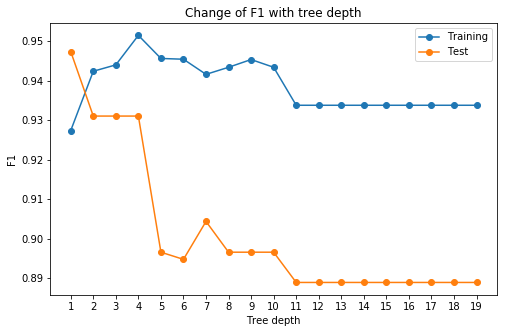

In [53]:
# Plot the F1 values obtained when varying the depth of the tree
min_depth = 1
max_depth = 20
f1_train = []
f1_test = []
for i in range(min_depth, max_depth):
    # Define the tree
    tree = DecisionTreeClassifier(
        random_state=0, max_depth=i).fit(X.train, Y.train)
    # Evaluate with the training split, using CV, cv times.
    # Append the result to the array for later plotting.
    f1_train.append(
        np.mean(cross_val_score(tree, X.train, Y.train, cv=10, scoring='f1')))

    # Train a tree with the entire training split
    tree = DecisionTreeClassifier(
        random_state=0, max_depth=i).fit(X.train, Y.train)
    
    # Evaluate the model trained with the entire training set, 
    # over the hold out set
    f1_test.append(f1_score(Y.test, tree.predict(X.test)))
    del(tree)

plot_metrics(f1_train, f1_test, 'Change of F1 with tree depth')

In [87]:
opt_tree = DecisionTreeClassifier(
    random_state=0, max_depth=4).fit(X.train, Y.train)

mse_values = cross_val_score(opt_tree, X.train, Y.train, scoring="f1")
opt_training_f1 = np.mean(mse_values)
print('F1 (training average): {:.4f}'.format(opt_training_f1))

opt_test_f1 = f1_score(Y.test, opt_tree.predict(X.test))
print('F1 (test): {:.4f}'.format(opt_test_f1))

F1 (training average): 0.9538
F1 (test): 0.9310


**Compare** the results with the optimal tree, against the base tree grown using suboptimal max_depth.

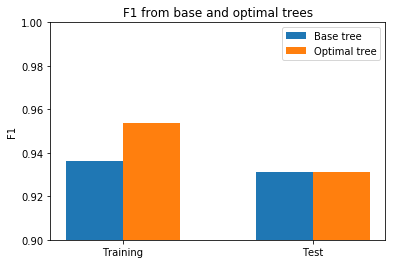

In [88]:
base = [base_training_f1, base_test_f1]
opt = [opt_training_f1, opt_test_f1]

barWidth = 0.3
r1 = np.arange(len(base))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, base, width = barWidth, label='Base tree')
plt.bar(r2, opt, width = barWidth, label='Optimal tree')
plt.xticks([r + barWidth/2 for r in range(len(base))], ['Training', 'Test'])
plt.title('F1 from base and optimal trees')
plt.ylim([0.9, 1.0])
plt.ylabel('F1')
plt.legend()
plt.show()

### Grid search

What is the optimal depth for this tree given the results obtained with CV? Instead of looking at a plot, we can use the grid search over the parameters we want to try, and for the range of values we decide. The result is a much simpler approach to the problem where you don't have to write the loop, and a single call does all the job for you.

In [97]:
parameters = {'max_depth':range(min_depth, max_depth)}
grid_tree = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
grid_tree.fit(X.train, Y.train)
best_tree = grid_tree.best_estimator_
print('Optimal accuracy: {:.4f}, for max_depth={}'.format(
    grid_tree.best_score_, grid_tree.best_params_['max_depth']))

Optimal accuracy: 0.9233, for max_depth=4


What is the score, for the TEST set, of that optimal tree? Let's use `cross_val_score` again to check it over the test set, using the best model from the previous step.

In [98]:
grid_score = f1_score(Y.test, grid_tree.best_estimator_.predict(X.test))
print('Test score for 4-deep best tree: {:.2f}'.format(grid_score))

opt_score = f1_score(Y.test, opt_tree.predict(X.test))
print('Test score for 4-deep optimal tree: {:.2f}'.format(opt_score))

Test score for 4-deep best tree: 0.88
Test score for 4-deep optimal tree: 0.93


Surprisingly, our score using the best model trained using grid search is producing a worse result than the optimal model obtained when looking for the optimal tree depth manually, in the previous section. 

**Why?**

The best estimator obtained in grid search is being trained on a smaller subset of the training set, and though it is the best of all possible estimators in the grid search it is not as good as the optimal model trained with the entire training set.

### Working with the probabilities of the estimations

The predicted class probability is the fraction of samples of the same class in a leaf. We can apply __laplace smoothing__ or play with the __threshold__ to be applied to consider when to assign a leaf to each class to find better results than those obtained with the default 0.5 probability.

In the code below, we obetain the prediction probabilities for the 23rd sample in the test set.

In [20]:
sample = X.test.iloc[23, :].values.reshape(1, -1)
leaf_id = classifier.apply(sample)

print('Leaf node ID: ', leaf_id)
print('Decision path:\n', classifier.decision_path(sample), sep='')
print('Probabilities:', classifier.predict_proba(sample))
print('Nr. of samples of leaf node:', classifier.tree_.n_node_samples[leaf_id])
print('Impurity (Gini) of leaf node:', classifier.tree_.impurity[leaf_id])
print('Samples from each class:', classifier.tree_.value[leaf_id])

Leaf node ID:  [9]
Decision path:
  (0, 0)	1
  (0, 6)	1
  (0, 8)	1
  (0, 9)	1
Probabilities: [[0.4137931 0.5862069]]
Number of samples of leaf node: [29]
Impurity (Gini) of leaf node: [0.48513674]
Samples from each class: [[[12. 17.]]]


## Optimization techniques

### Bagging

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

We're producing `cv` splits, and for each of them we're growing 100 trees, each with a bootstrapped sample of the training set, to produce a classification, based on voting (hard or soft).

In [21]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=4), 
                            n_estimators=100,
                            max_samples=0.5, 
                            max_features=len(wholesale.names('features')),
                            oob_score=True,
                            random_state=0, n_jobs=-1)
bagging.fit(X.train, column_or_1d(Y.train))
bagging_scores = cross_val_score(bagging, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(bagging_scores)
print('Avg. Score: {:.4f}'.format(avg_score))

Avg. Score: 0.9181


The result is much better than the one obtained by simply applying grid search over the max_depth parameters with cross-validation.

### Random Forests

Now, we're not only going to pick subsets of the training set to train a number of trees, but also to select subset of features. In the end, the classification will be performed by the avearege prediction made by the grown trees.

In [68]:
rf = RandomForestClassifier(n_estimators=100,
                            max_features=3,
                            max_depth=4,
                            oob_score=True,
                            random_state=0, n_jobs=-1)
rf.fit(X.train, column_or_1d(Y.train))
rf_scores = cross_val_score(rf, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(rf_scores)
print('Avg. Score: {:.4f}'.format(avg_score))

Avg. Score: 0.8944


The result is much better than the one obtained by simply applying grid search over the max_depth parameters with cross-validation, but slightly worse than in the bagging case.

### Boosting

Gradient Tree Boosting or Gradient Boosted Trees (GBT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

In [23]:
gb = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=1.0,
                                max_features=3,
                                max_depth=4, 
                                random_state=0)
gb.fit(X.train, column_or_1d(Y.train))
gb_scores = cross_val_score(gb, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(gb_scores)
print('Avg. Score: {:.4f}'.format(avg_score))

Avg. Score: 0.8819


In [24]:
gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=4,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Hyperparameter tuning

One of the most important phases in trees is deciding on what is the best combination of parameters that control the optimal values for

- depth of the tree, 
- min number of samples per leaf,
- min number of samples to perform a split,
- max number of features to consider when looking for the best split,
- ...

All these parameters control the growth of the tree, and given the lack of other pruning mechanisms, this is the best way of considering that your tree model gets "**pruned**" to avoid overfitting.

How to perform gridsearch or hyper parameter tuning over Gradient Boosting trees?


In [29]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.1, 0.5, 1.0],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[2, 3, 4],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10]
    }

grid_gb = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

# Grid search takes 10 or more minutes, so I disable it.
grid_gb.fit(X.train, column_or_1d(Y.train))  

score = grid_gb.score(X.train, column_or_1d(Y.train))
print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(grid_gb.best_params_))

Score: 0.9318
Best Params:
{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.2, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.8}


In [30]:
hpgb_scores = cross_val_score(
    grid_gb.best_estimator_, 
    X.test, 
    column_or_1d(Y.test), 
    cv=10)
avg_score = np.mean(hpgb_scores)
print('Avg. Score: {:.4f}'.format(avg_score))

Avg. Score: 0.8375


Surprisingly, for this particular problem and this dataset, we're not getting better results with GBoost, or we couldn't find the proper set of parameters.

In [110]:
optimal_gb = GradientBoostingClassifier(n_estimators=1000, 
                                        min_samples_leaf=0.05,
                                        min_samples_split=0.05,
                                        subsample=0.8,
                                        learning_rate=0.01,
                                        max_features='log2',
                                        max_depth=4, 
                                        random_state=0)
optimal_gb.fit(X.train, column_or_1d(Y.train))
gb_scores = cross_val_score(optimal_gb, X.test, column_or_1d(Y.test), cv=10)
avg_score = np.mean(gb_scores)
print('Avg. Score: {:.4f}'.format(avg_score))

Avg. Score: 0.8833


## Adding interpretability

The basic idea behind LIME and the general concept of bringing 'interpretability' to complex models is the following: train a model with the input features of the complex model, and learn the response given by the complex model to later explain what's the effect of each individual feature on the response.

The problem is that this approach is too simplistic and does not necessarily produces the right explanation to the phenomena learned by the complex model. In fact, any potential interaction between variables is not considered. Therefore, these ideas must be used with care.

Let's explore how LIME (Local Interpretable Model-agnostic Explanations) brings interpretability to our previously trained gradient boosting tree with the optimal parameters.

First of all print out the values we want to predict (random pick from the training set):

In [123]:
idx=333
print('Sample being traced\n-------------------------\n', 
      wholesale.data.iloc[idx, :], sep='')

Sample being traced
-------------------------
Region                  2
Fresh                8565
Milk                 4980
Grocery             67298
Frozen                131
Detergents_Paper    38102
Delicassen           1215
Name: 333, dtype: int64


This is the way LIME adds interpretability, this time, to a single prediction.

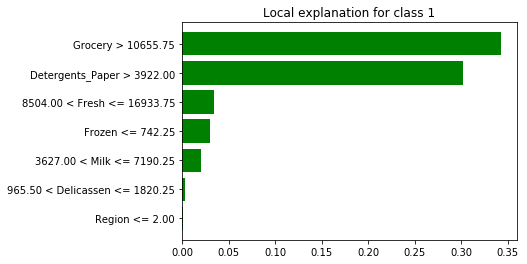

In [39]:
explainer = LimeTabularExplainer(
    wholesale.features.values, 
    mode='classification', 
    feature_names=wholesale.names('features'))

exp = explainer.explain_instance(wholesale.features.iloc[idx, :], 
    optimal_gb.predict_proba)

%matplotlib inline
p = exp.as_pyplot_figure();

### Interpretability, through simple surrogate models

Let's build a dataset with the input features as they're, and the target variable being the output from the gradient boosting model trained before.

In [122]:
input_cols = wholesale.features
predictions = optimal_gb.predict(wholesale.features)
output_col = pd.Series(data=predictions, name='Channel')
predicted_df = pd.concat([input_cols, output_col], axis=1)

ws = Dataset.from_dataframe(predicted_df)
ws.set_target('Channel')

print('Sample being traced\n-------------------------\n', 
      ws.data.iloc[idx, :], sep='')

Sample being traced
-------------------------
Region                  2
Fresh                8565
Milk                 4980
Grocery             67298
Frozen                131
Detergents_Paper    38102
Delicassen           1215
Name: 333, dtype: int64


Build a simple decision tree with the same input features as the gradient boosting tree, but with its predictions as target variable. The tree is a single tree, but will help us to see if the decision process is similar to that followed by the GB tree.

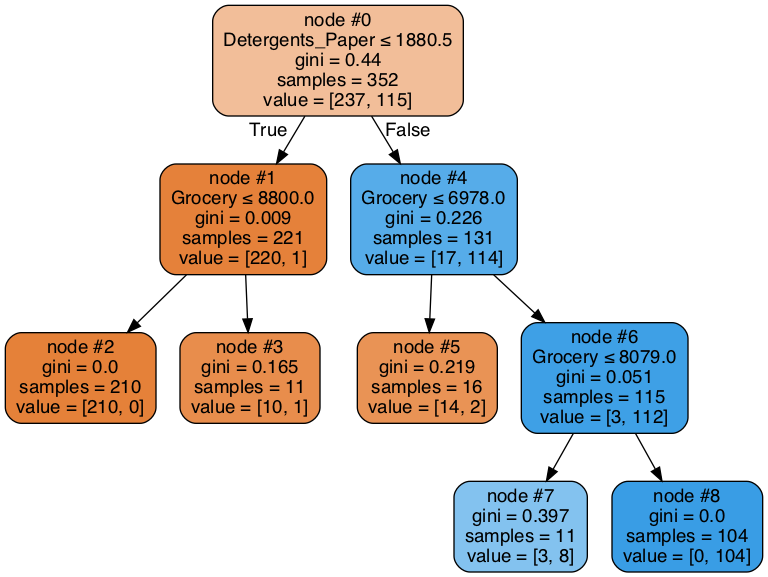

In [111]:
X, Y = ws.split()
surrogate = DecisionTreeClassifier(
    min_samples_leaf=10,
    min_samples_split=10,
    random_state=0, 
    max_depth=3)
surrogate.fit(X.train, Y.train)

display_tree(surrogate, ws.names('features'))

Let's reproduce what is the decision path for the entry selected, to see what nodes are shaping the decision in the surrogate model:

In [115]:
print('Index selected: {}'.format(idx))
path = surrogate.decision_path(X=ws.features.iloc[idx, :].values.reshape(1, -1))
print('Decision Path:\n', path, sep='')
prediction = surrogate.predict(
    ws.features.iloc[idx, :].values.reshape(1, -1))
print('Prediction by surrogate model: {}'.format(prediction[0]))
print('Actual response for idx({}): {}'.format(idx, wholesale.target[idx]))

Index selected: 333
Decision Path:
  (0, 0)	1
  (0, 4)	1
  (0, 6)	1
  (0, 8)	1
Prediction by surrogate model: 2
Actual response for idx(333): 2


When plotting the features importance coming from the surrogate models, we can check that the two most important features that shape the classification decision match those coming from the LIME package: Detergents_paper and Grocery. 

However, this simpler model is not able to add any importance to the rest of the features, probably because of its simplicity and low depth. We can also build an alternate interpretation with surrogate models by fitting a logistic regression and checking the coefficients.

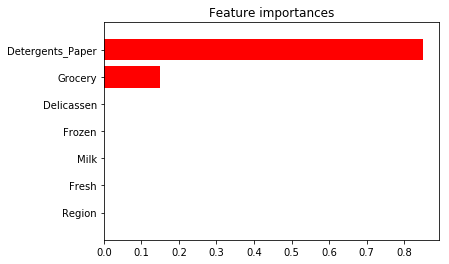

In [116]:
features_importance(surrogate, X)

# Isolation Trees

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Automatically created module for IPython interactive environment


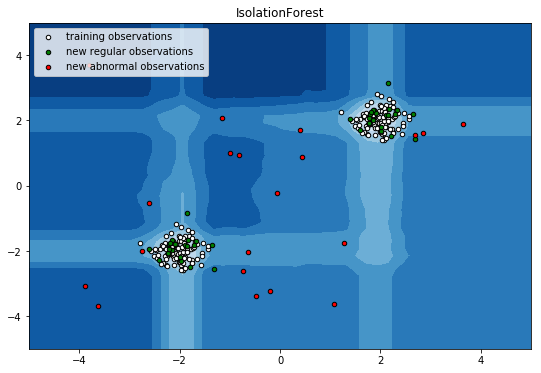

In [92]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=rng, contamination='auto')
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(9,6))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show();

## Example with Mopsi location dataset

Dataset and info [here](https://cs.joensuu.fi/sipu/datasets/)

![](https://cs.joensuu.fi/sipu/datasets/MopsiLocations2012-Joensuu.jpg)

In [73]:
fi = Dataset('/Users/renero/Desktop/MopsiLocations2012-Joensuu.txt',
             sep=' ', header=None, names=['X1', 'X2'])
fi.data.head(5)

,X1,X2
0,62.59809,29.74448
1,62.59809,29.74448
2,62.59809,29.74448
3,62.61943,29.69410
4,62.60326,29.74494


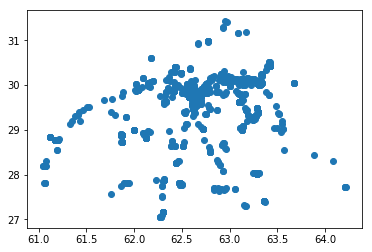

In [74]:
plt.scatter(fi.data.X1, fi.data.X2)

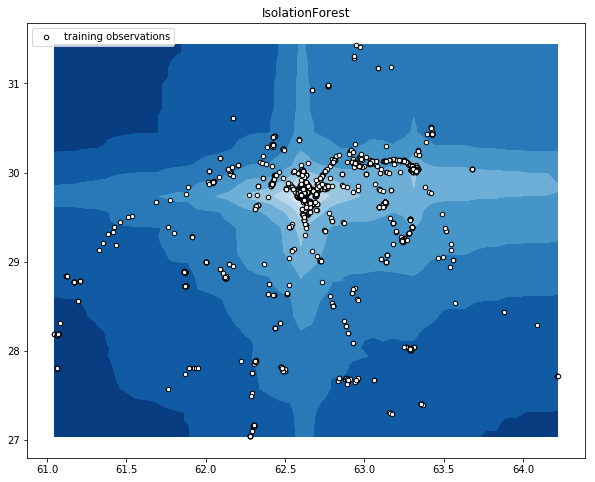

In [94]:
# fit the model
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=rng, contamination='auto')
clf.fit(fi.data)
y_pred_train = clf.predict(fi.data)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(fi.data.iloc[:, 0].min(), fi.data.iloc[:, 0].max(), 50),
                     np.linspace(fi.data.iloc[:, 1].min(), fi.data.iloc[:, 1].max(), 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(fi.data.iloc[:, 0], fi.data.iloc[:, 1], c='white',
                 s=20, edgecolor='k')
plt.axis('tight')
plt.legend([b1, b2],
           ["training observations"],
           loc="upper left")
plt.show()